# 수익 예측 모델

### index
1. 데이터셋 load
2. 데이터 전처리
    - json형 값을 갖는 컬럼 펼치기
    - 수치형 데이터로 형변환
    - 결측치 처리
3. 상관관계 분석
4. 이상치(outlier)값을 갖는 행 제거
5. 모델 target(totals.transactionRevenue)을 예측하는데 불필요한 컬럼 제거
6. train, valid, test 셋으로 split
7. 모델 훈련

In [130]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

%matplotlib inline

import lightgbm as lgb
from lightgbm import early_stopping
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error

## 1. 데이터셋 load

In [53]:
train_path = '/Volumes/Expansion/google_analytics_customer/train.csv'
test_path = '/Volumes/Expansion/google_analytics_customer/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_12274/1646842768.py:4: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_12274/1646842768.py:5: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



### train, test dataframe 확인

In [54]:
train_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [55]:
train_df.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [57]:
test_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""4""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024
1,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0643697640977915618,"{""continent"": ""Europe"", ""subContinent"": ""South...",0643697640977915618_1508175522,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,1,1508175522
2,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""7"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,1,1508143220
3,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2376720078563423631,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""8"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508193530,1,1508193530
4,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2314544520795440038,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""9"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508217442,1,1508217442


In [58]:
test_df.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       804684 non-null  object
 1   date                  804684 non-null  int64 
 2   device                804684 non-null  object
 3   fullVisitorId         804684 non-null  object
 4   geoNetwork            804684 non-null  object
 5   sessionId             804684 non-null  object
 6   socialEngagementType  804684 non-null  object
 7   totals                804684 non-null  object
 8   trafficSource         804684 non-null  object
 9   visitId               804684 non-null  int64 
 10  visitNumber           804684 non-null  int64 
 11  visitStartTime        804684 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 73.7+ MB


## 2. 데이터 전처리

### 1) json형 값을 갖는 컬럼 펼치기

In [59]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'} # Important!!
                    )

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])  # ✅ 최신 방식 적용
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [106]:
train_df = load_df('/Volumes/Expansion/google_analytics_customer/train.csv')
test_df = load_df('/Volumes/Expansion/google_analytics_customer/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [62]:
train_df.loc[:2]

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

## 2) 컬럼 사전 제거

### (1) Constant value를 갖는 컬럼
- 모든 행이 같은 값을 가지고 있는 컬럼 조회

In [107]:
df = train_df.copy()

const_cols = [c for c in df.columns if df[c].nunique(dropna=False)==1]

const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

### (2) train_df에 있지만, test_df에 없는 컬럼 조회
- 존재할 시 train_df에서 제거 (target : totals.transactionRevenue는 제외)

In [108]:
diff_cols = list(set(train_df.columns) - set(test_df.columns))

diff_cols

['totals.transactionRevenue', 'trafficSource.campaignCode']

### (3) `const_cols`, `trafficSource.campaignCode` + `sessionId` 제거

In [109]:
cols_to_drop = const_cols + ['sessionId']

df = df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [110]:
print("Train DataFrame Length : ", len(df.columns))
print("Test DataFrame Length : ", len(test_df.columns))
print("두 데이터프레임의 컬럼 차이 : ", set(df.columns)-set(test_df.columns))

Train DataFrame Length :  34
Test DataFrame Length :  33
두 데이터프레임의 컬럼 차이 :  {'totals.transactionRevenue'}


## 3) 결측치 처리
- totals.transactionRevenue 결측치 처리 : NaN -> 0 대체
- target 추출

In [111]:
df['totals.transactionRevenue'].fillna(0, inplace=True)
train_y = df['totals.transactionRevenue'].values

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_12274/1196167568.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





## 4) 범주형, 수치형 데이터 처리

### (1) label encoding : categorical features -> numerical features
- 모델 훈련을 위해 object 데이터를 숫자형으로 변환

In [112]:
cat_cols = ['channelGrouping', 'device.browser', 'device.deviceCategory',
            'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent',
            'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
            'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent',
            'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot',
            'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium',
            'trafficSource.referralPath', 'trafficSource.source',
            'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.isTrueDirect']

for col in cat_cols :
    print(col)
    lbl = preprocessing.LabelEncoder()
    # 같은 값은 같은 정수로 인코딩하기 위해 train_df(df)와 test_df 합치기
    lbl.fit(list(df[col].values.astype('str')) + list(test_df[col].values.astype('str')))

    df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


### (2) numeric features : float 형변환
- object형이었던 수치형 컬럼을 실제 숫자(float)로 형변환

In [113]:
num_cols = ['totals.hits', 'totals.pageviews', 'visitNumber',
            'visitStartTime', 'totals.bounces', 'totals.newVisits']

for col in num_cols :
    print(col)
    df[col] = df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

totals.hits
totals.pageviews
visitNumber
visitStartTime
totals.bounces
totals.newVisits


# 3. 데이터 분할

### (1). 날짜 기준으로 data split
- Train : 2017-05-31 이전
- Valid : 2017-05-31 이후

In [114]:
# date 기준 split을 위한 데이터 전처리
df['date'] = df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

# split
df_train = df[df['date'] <= datetime.date(2017, 5, 31)]
df_valid = df[df['date'] > datetime.date(2017, 5, 31)]

### (2). target 로그 변환
- 앞선 EDA에서 totals.transactionRevenue에 NaN값이 대부분이었고, 정상값은 그 수치가 극단적으로 크기도 했음을 확인했었음
- 따라서 log1p()로 로그변환하여 모델이 예측하기 쉽게 전처리

In [ ]:
# log변환을 위한 숫자형으로 형변환
df_train['totals.transactionRevenue'] = pd.to_numeric(df_train['totals.transactionRevenue'].fillna(0))
df_valid['totals.transactionRevenue'] = pd.to_numeric(df_valid['totals.transactionRevenue'].fillna(0))

In [ ]:
# 로그 변환
y_train = np.log1p(df_train['totals.transactionRevenue'].values)
y_valid = np.log1p(df_valid['totals.transactionRevenue'].values)

### (3) train/valid/test 입력값으로 split
- 모델에 넣을 특성(feature)들만 추출

In [121]:
train_X = df_train[cat_cols + num_cols]
valid_X = df_valid[cat_cols + num_cols]
test_X = test_df[cat_cols + num_cols]

# 4. 모델 훈련 및 추론

### (1) LightGBM 모델 훈련

In [133]:
# 훈련 함수 정의
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression", # 회귀
        "metric" : "rmse",          # 평가지표
        "num_leaves" : 50,          # 트리 복잡도
        "min_child_samples" : 100,  # 과적합 방지를 위한 최소 데이터 수
        "learning_rate" : 0.1,      # 학습률
        "bagging_fraction" : 0.7,   # 샘플링 비율 (row)
        "feature_fraction" : 0.5,   # 피처 샘플링 비율 (column)
        "bagging_frequency" : 5,    # 5라운드마다 bagging 수행
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    # 데이터셋
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    # 모델 훈련 (1000라운드 훈련, 검증 성능이 100번 안 좋아지면 중단)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], callbacks=[early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)])
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(train_X, y_train, valid_X, y_valid, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.69465
[200]	valid_0's rmse: 1.69291
Early stopping, best iteration is:
[179]	valid_0's rmse: 1.69248


### (2) Metrics 확인

In [140]:
# 수익 예측이 음수인 경우 제거
pred_val[pred_val < 0] = 0

# 예측값 데이터프레임 생성
val_pred_df = pd.DataFrame({"fullVisitorId":df_valid["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = df_valid["totals.transactionRevenue"].values
# 로그변환되었던 수익 예측값을 원래 범위로 변환
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

# 사용자 단위로 집계
val_pred_df = val_pred_df.groupby("fullVisitorId")[["transactionRevenue", "PredictedRevenue"]].sum().reset_index()

val_pred_df['transactionRevenue'].value_counts()
# 예측값, 실제값 모두 로그 변환 후 비교
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.7134148561586342


### (3) 예측 결과 시각화

#### 평가지표
1. RMSLE - Root Mean Squared Log Error
2. RMSE - Root Mean Squared Error
3. MAE - Mean Absolute Error
4. R² Score - 결정계수

RMSLE : 1.7134148561586342
RMSE  : 70648574.43783036
MAE   : 2302849.147320144
R2    : 0.4318954364043509


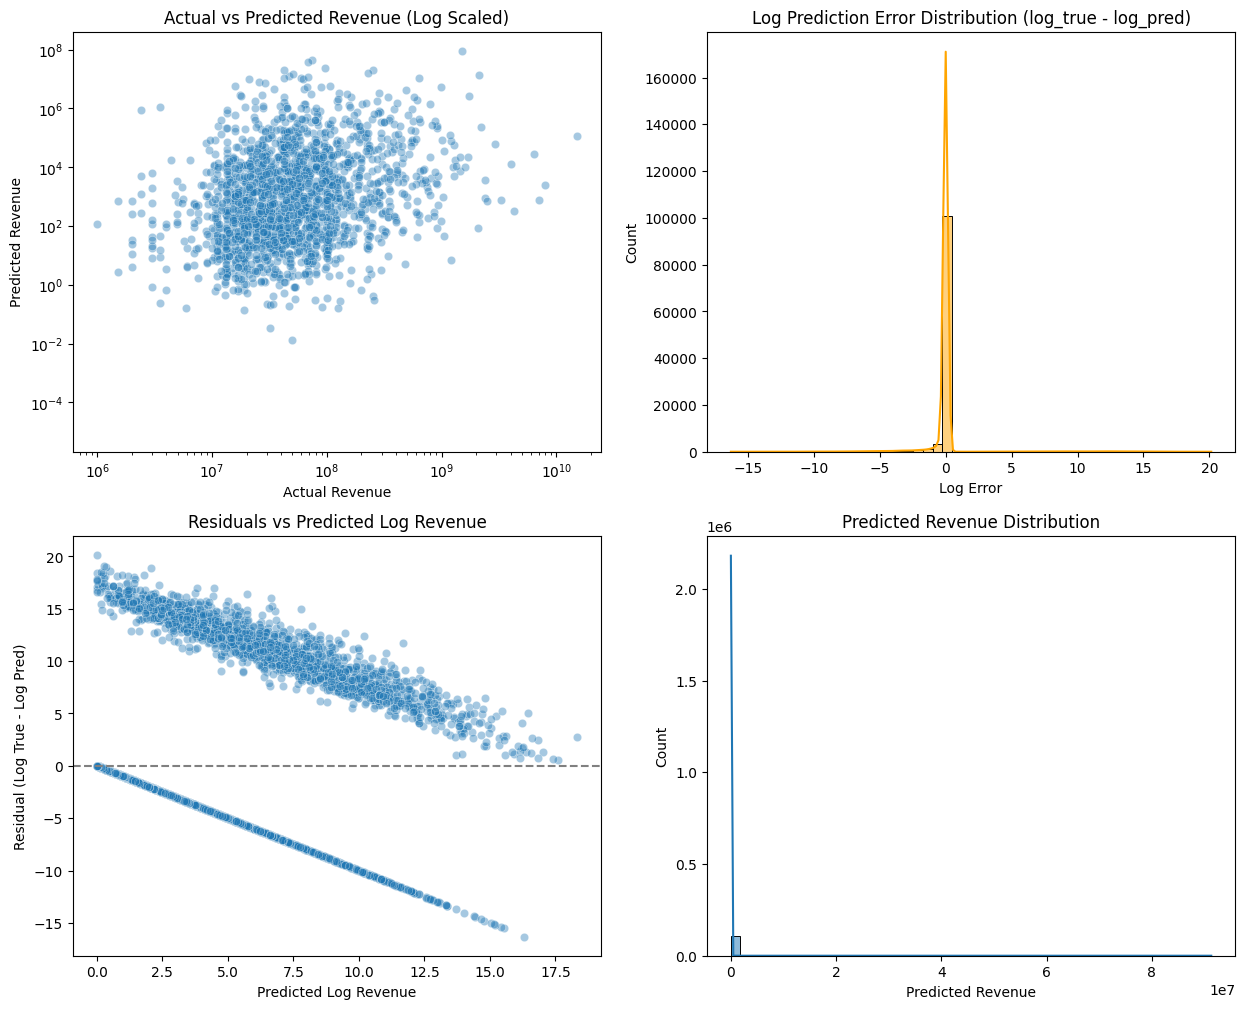

In [162]:
# 로그 예측값 복원
val_pred_df['log_true'] = np.log1p(val_pred_df['transactionRevenue'])
val_pred_df['log_pred'] = np.log1p(val_pred_df['PredictedRevenue'])
val_pred_df['error'] = val_pred_df['log_true'] - val_pred_df['log_pred']

# 평가지표 출력
print('RMSLE :', np.sqrt(metrics.mean_squared_error(val_pred_df['log_true'], val_pred_df['log_pred'])))
print('RMSE  :', np.sqrt(metrics.mean_squared_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue'])))
print('MAE   :', metrics.mean_absolute_error(val_pred_df['transactionRevenue'], val_pred_df['PredictedRevenue']))
print('R2    :', metrics.r2_score(val_pred_df['log_true'], val_pred_df['log_pred']))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

## 1. 실제 vs 예측 산점도
sns.scatterplot(data=val_pred_df, x='transactionRevenue', y='PredictedRevenue', ax=axes[0,0], alpha=0.4)
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('Actual vs Predicted Revenue (Log Scaled)')
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')

## 2. 로그 에러 분포
sns.histplot(val_pred_df["error"], bins=50, kde=True, ax=axes[0, 1], color="orange")
axes[0, 1].set_title("Log Prediction Error Distribution (log_true - log_pred)")
axes[0, 1].set_xlabel("Log Error")
axes[0, 1].set_ylabel("Count")

## 3. 잔차(residuals) vs 예측값
sns.scatterplot(x="log_pred", y="error", data=val_pred_df, ax=axes[1, 0], alpha=0.4)
axes[1, 0].axhline(0, linestyle="--", color="gray")
axes[1, 0].set_title("Residuals vs Predicted Log Revenue")
axes[1, 0].set_xlabel("Predicted Log Revenue")
axes[1, 0].set_ylabel("Residual (Log True - Log Pred)")

## 4. 예측값 분포
sns.histplot(val_pred_df["PredictedRevenue"], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Predicted Revenue Distribution")
axes[1, 1].set_xlabel("Predicted Revenue")
axes[1, 1].set_ylabel("Count")

plt.show()